# Medicaid Project

In [1]:
import pandas as pd
import numpy as np

# packages for preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# packages for model
from sklearn.ensemble import GradientBoostingRegressor

# packages for model evaluation
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import roc_auc_score

from sklearn.inspection import PartialDependenceDisplay, plot_partial_dependence

import matplotlib.pyplot as plt

## 1. Read in data

In [2]:
df = pd.read_csv("final.csv")

In [3]:
df.head(2)

,FC,OT,JC,E,A,D,I,FJ,IE,F,...,duration,target,age_lastyear,GENDER,HHSIZE,num_kids_lastyear,novehicle,work_income,nonwork_income,total_income
0,1,0,1,0,0,0,0,0,0,0,...,3.0,1,40.0,F,4.0,3.0,1,0.0,29472.0,29472.0
1,1,0,1,0,0,0,0,0,0,0,...,3.0,0,32.0,M,1.0,0.0,0,0.0,0.0,0.0


## Data Dictionary

1. ['FC ', 'OT ', 'JC ', 'E  ', 'A  ', 'D  ', 'I  ', 'FJ ', 'IE ', 'F  ','FA ', 'B  ', 'AC ', ' C ', 'IC ', 'AH ', ' E ', 'JF ', 'EF '] 
these columns are binary indicators, suggesting what the type of medcaid program the participant is in. Specifically,

           A  Aged
           B  Blind
           D  Disabled
           E  Medically Needy
           I  Institutional Medicaid
           FC (ACA) Family Care (Only)
           JC Jersey Care (Only)
           IE Institutional (Medically Needy)
           IH Institutional (Assisted Living)
           OT Other

Some cases have combined programs, Combine The Case Types, e.g., FA - Family Care & Aged
   
2. 'duration', number of years the participant is in the program (from the starting date to the last applciation date)
3. 'age_lastyear', the age of applicant (in the last application year)
4. 'GENDER', applicant gender as recorded in the system. F indicates female, M indicates male, there are also empty values, which may indicates other or simply missing.
5. 'HHSIZE', household size
6. 'num_kids_lastyear', number of kids in the household by the time of the last application
7. 'novehicle', a binary indicator suggesting whether the household has no vehicle. The value will be 1 if the household does not have access to a vehicle
8. 'work_income', annual income from work (estimated by multiplying each pay check with frequency, the data were messy so some numbers are very large, you may need to decide wether you want to remove outliers)
9. 'nonwork_income', annual income from non-work sources, e.g., pension. 
10. 'total_income', the summation of the work and non-work related income


Target variable is the 'target'. It's a binary variable indicating whether the applicant successfully left the program or not. 

## 2. Data Preprocessing

In [4]:
# 2.1 Split data into training (80%) and testing (20%) data
X = df.drop("target" , axis = 1)
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2
                                                    , random_state=0)

In [5]:
#2.2 What column in X_train has missing values and what percent have missing values?
# show columns with % of missing values
X_train.isnull().sum()/len(X_train)

FC                   0.000000
OT                   0.000000
JC                   0.000000
E                    0.000000
A                    0.000000
D                    0.000000
I                    0.000000
FJ                   0.000000
IE                   0.000000
F                    0.000000
FA                   0.000000
B                    0.000000
AC                   0.000000
 C                   0.000000
IC                   0.000000
AH                   0.000000
 E                   0.000000
JF                   0.000000
EF                   0.000000
duration             0.000000
age_lastyear         0.209350
GENDER               0.209011
HHSIZE               0.000678
num_kids_lastyear    0.000000
novehicle            0.000000
work_income          0.000000
nonwork_income       0.000000
total_income         0.000000
dtype: float64

In [6]:
# Let's drop records with missing values before we develop machine learning models, hint please use the dropna function that comes with pandas dataframe to drop records with missing values (e.g., if you want to drop all records with na values in df dataframe, then the code is df = df.dropna())
# your code here to drop na
X_train = X_train.dropna()
y_train = y_train[X_train.index]

In [7]:
X_train.isnull().sum()

FC                   0
OT                   0
JC                   0
E                    0
A                    0
D                    0
I                    0
FJ                   0
IE                   0
F                    0
FA                   0
B                    0
AC                   0
 C                   0
IC                   0
AH                   0
 E                   0
JF                   0
EF                   0
duration             0
age_lastyear         0
GENDER               0
HHSIZE               0
num_kids_lastyear    0
novehicle            0
work_income          0
nonwork_income       0
total_income         0
dtype: int64

In [8]:
X_train = pd.get_dummies(X_train, drop_first = True)

In [9]:
X_train.head(2)

,FC,OT,JC,E,A,D,I,FJ,IE,F,...,EF,duration,age_lastyear,HHSIZE,num_kids_lastyear,novehicle,work_income,nonwork_income,total_income,GENDER_M
2096,1,0,0,0,0,0,0,0,0,0,...,0,1.0,26.0,4.0,1.0,0,90126.40,0.0,90126.40,0
1013,1,0,0,0,0,0,0,0,0,0,...,0,3.0,32.0,3.0,1.0,0,43059.38,0.0,43059.38,0


## 3. Data Balancing

In [10]:
#3.1 How many ones (i.e., people who successfulll leave the program) and zeros (i.e., people who are still in the program) are there in your training target?
y.value_counts()

0    2219
1    1472
Name: target, dtype: int64

In [11]:
# 3.2 The data is unbalanced as there are more zeros than ones. Customize the code to balance the training data using the upsampling method.
df_train = X_train.copy()
df_train["target"] = y_train

df_minority = df_train[df_train["target"] == 1]
df_majority = df_train[df_train["target"] == 0]
df_upsampled = resample(df_minority, n_samples = len(df_majority), replace=True)
df_upsampled = pd.concat([df_upsampled, df_majority])
X_train_upsampled = df_upsampled.drop("target", axis = 1)
y_train_upsampled = df_upsampled["target"]

## 4. Gradient Boosting Classifier Tuning

4.1 Evaluation metrics selection. If Union County director is concerned about both the recall and precision of the model, what metrics do you suggest to use to evaluate model performance?

If either the recall or precision is used then it is going to be biased so I suggest the F1 because it is used to include the recall and precision of the model.

4.2 Customize the code to fine tune a gradient boosting classifier given the selected metrics.

Please ensure the following hyperparameters are finetuned:
1. n_estimators
2. max_depth
3. learning_rate
4. max_features
5. min_samples_split

In [12]:
# customize the code.
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score # load gridserach cross validation package

space  = [Integer(60,100, name="n_estimators"),
          Integer(5, 8, name='max_depth'), #integers
          Integer(2, 9, name='max_features'),
          Integer(100, 150, name='min_samples_split'),
          Real(0.0001, 0.1, name='learning_rate')] 

gb  =  GradientBoostingClassifier(random_state=0)

@use_named_args(space)
def objective(**params):
    gb.set_params(**params)

    return -np.mean(cross_val_score(gb, X_train_upsampled, y_train_upsampled,
                                   cv=5, n_jobs=-1,scoring="f1"))

gb_gp = gp_minimize(objective, space, n_calls=50, random_state=0)

"Best score=%.4f" % gb_gp.fun

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pac

'Best score=-0.8107'

In [13]:
# 4.3 What are the best combination of the hyperparameter?
# below are old codes from class, you need to customize the code.
print("""Best parameters:
- n_estimators = %d
- max_depth=%d
- max_features=%d
- min_samples_split=%d
- learning_rate=%s""" % (gb_gp.x[0], gb_gp.x[1],
                            gb_gp.x[2], gb_gp.x[3], gb_gp.x[4]))

Best parameters:
- n_estimators = 100
- max_depth=8
- max_features=8
- min_samples_split=100
- learning_rate=0.1


## 5. Testing Model Peformance on the Test Dataset

In [14]:
# 5.1 drop records with na values in X_test
X_test = X_test.dropna()
y_test = y_test[X_test.index]
X_test = pd.get_dummies(X_test, drop_first = True)

In [15]:
# 5.2 Develop Gradient Boosting Model with the best hyperparameters using the training set
best_gb = GradientBoostingClassifier(n_estimators=100,
                                     max_depth=8,
                                     max_features=9,
                                     min_samples_split=100,
                                     learning_rate=0.1,)
# initialize your gradient boosting model with the hyperparameters you got from 4.3
best_gb.fit(X_train_upsampled, y_train_upsampled) 
# customize inputs so that the model is fitted to your training datasets

GradientBoostingClassifier(max_depth=8, max_features=9, min_samples_split=100)

In [16]:
# 5.3 Apply the train GBM to test dataset
# customize predict function inputs so the model predict outcomes for the testing datasets
y_predict = best_gb.predict(X_test)

5.4 Calculate the following evaluation metrics for the model output

1. Precision
2. Recall
3. f1 score
4. Confusion matrix
4. ROC

Do you think the model outfit the training data set? 

In [17]:
# customize the code to get Precsion, Recall, and F1 score
precision, recall, fscore, support = score(y_test, y_predict) #support = no. of observations in each category
df_rf = pd.DataFrame({
    "labels":list(range(len(y_test.value_counts().index))),
    'precision':precision,
    "recall": recall,
    "fscore": fscore,
    "support": support # number of cases in the category in the observed dataset
    
})

df_rf

,labels,precision,recall,fscore,support
0,0,0.805634,0.785714,0.795549,364
1,1,0.673640,0.700000,0.686567,230


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


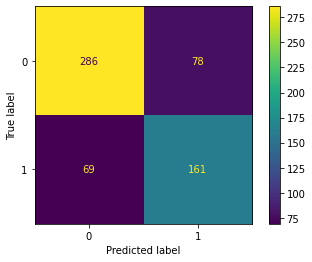

In [18]:
# customize the code to get confusion matrix
plot_confusion_matrix(best_gb , X_test, y_test)
plt.savefig("figures/confusion_matrix.pdf")

In [19]:
# customize the code here to get confusion matrix
y_predict_proba = best_gb.predict_proba(X_test)
roc_auc_score (y_test, y_predict_proba[:,1])

0.8194278547539418

## 6 Interprete Model Results

In [20]:
# 6.1 What are the top 6 important features from the model?
gb_imp_score = pd.DataFrame({
    "features" : X_train.columns,
    "score" : best_gb.feature_importances_})
gb_imp_score.sort_values("score", ascending = False).head(6)

,features,score
19,duration,0.451073
20,age_lastyear,0.109643
26,total_income,0.091913
25,nonwork_income,0.088892
24,work_income,0.077240
2,JC,0.042086


In [21]:
feature_list = gb_imp_score.sort_values("score", ascending = False).head(6)["features"].values.tolist()

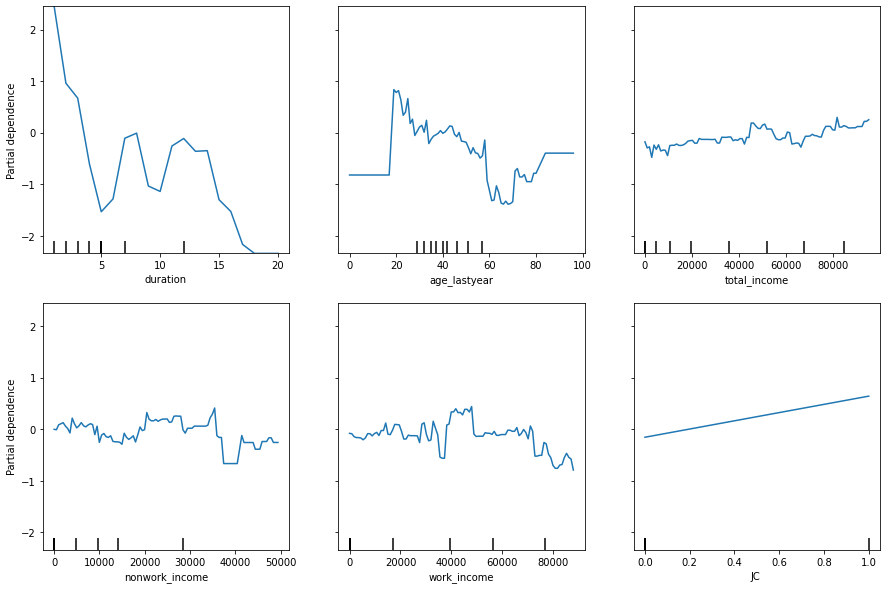

In [22]:
# 6.2 PDP plots
# Generate pdp plots to each of the top 6 important features
# customized code below to show PDP plots
figure = plt.figure(figsize = (15, 10))
ax = figure.add_subplot(1,1,1)
PartialDependenceDisplay.from_estimator(best_gb, pd.concat([X_test, X_train]),feature_list, ax =ax) 
plt.savefig("figures/PDPs.pdf")

In [23]:
# 6.3 Interactions
# Please examine if there is any interations among the top 6 important features in the model using the contour PDP plots. You don't have to exhaust all combinations, but just a couple that you believe may have interactions.
X_train.columns

Index(['FC ', 'OT ', 'JC ', 'E  ', 'A  ', 'D  ', 'I  ', 'FJ ', 'IE ', 'F  ',
       'FA ', 'B  ', 'AC ', ' C ', 'IC ', 'AH ', ' E ', 'JF ', 'EF ',
       'duration', 'age_lastyear', 'HHSIZE', 'num_kids_lastyear', 'novehicle',
       'work_income', 'nonwork_income', 'total_income', 'GENDER_M'],
      dtype='object')

In [24]:
for idx, feature in enumerate(X_train.columns):
    print (idx, feature)

0 FC 
1 OT 
2 JC 
3 E  
4 A  
5 D  
6 I  
7 FJ 
8 IE 
9 F  
10 FA 
11 B  
12 AC 
13  C 
14 IC 
15 AH 
16  E 
17 JF 
18 EF 
19 duration
20 age_lastyear
21 HHSIZE
22 num_kids_lastyear
23 novehicle
24 work_income
25 nonwork_income
26 total_income
27 GENDER_M


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


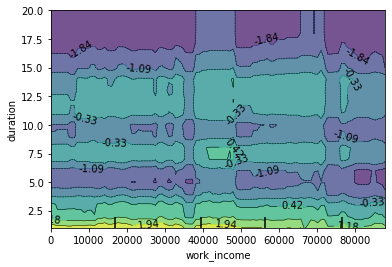

In [25]:
# customized code to show interaction plots, add cells below to explore more combinations
plot_partial_dependence (best_gb, pd.concat([X_test, X_train]), [(24,19 )],
                                  feature_names=X_train.columns)
plt.savefig("figures/Interactions_duration+num_kids_lastyear.pdf")

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_partial_dependence is deprecated; Function `plot_partial_dependence` is deprecated in 1.0 and will be removed in 1.2. Use PartialDependenceDisplay.from_estimator instead
  warnings.warn(msg, category=FutureWarning)


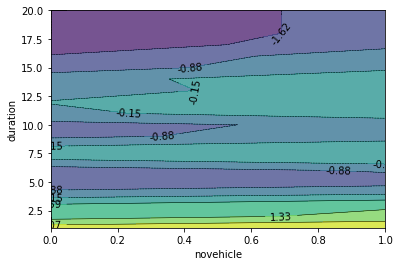

In [26]:
# customized code  to show interaction plots, add cells below to explore more combinations
plot_partial_dependence (best_gb, pd.concat([X_test, X_train]), [(23, 19)],
                                  feature_names=X_train.columns)
plt.savefig("figures/Interactions_duration+novehicle.pdf")